# Ventilation Duration Analysis in ICU Patients (MIMIC-IV)

This project analyzes the duration of mechanical ventilation in ICU patients using a derived dataset from the MIMIC-IV database.
The goal is to explore ventilation patterns and their relationship with clinical outcomes and patient demographics.

**Technologies:** Python, pandas, matplotlib, SQL (SQLite)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

## 1. Data Loading

In [9]:
# Load dataset
generic_db = pd.read_csv("C:\\Users\\clau_\\OneDrive\\Desktop\\Missing values imputation\\Dataset\\dataset.csv")
generic_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8129 entries, 0 to 8128
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   subject_id                       8129 non-null   int64  
 1   hadm_id                          8129 non-null   int64  
 2   stay_id                          8129 non-null   int64  
 3   gender                           8129 non-null   object 
 4   age                              8129 non-null   int64  
 5   icu_intime                       8129 non-null   object 
 6   icu_outtime                      8129 non-null   object 
 7   vent_starttime                   8129 non-null   object 
 8   vent_endtime                     8129 non-null   object 
 9   ventilation_status               8129 non-null   object 
 10  dod                              8129 non-null   object 
 11  vent_duration                    8129 non-null   object 
 12  ventend_to_death    

## 2. Data Cleaning and Feature Selection

In [10]:
#Check the number of NaNs for each variable (column)
nan_ratio = generic_db.isna().mean()
nan_ratio.sort_values(ascending=False)
#Check all the variables with > 50% of NaNs
cols_to_drop = nan_ratio[nan_ratio > 0.5].index
#Delete all the variables with >50% of NaNs and the column "height" which is not useful to the scope.
db_clean = generic_db.drop(columns=cols_to_drop.union(['height']))

## 3. Ventilation Duration Computation

In [11]:
# Calculate the difference between variables endtime and starttime in order to have the total time of ventilation 
db_clean['vent_starttime'] = pd.to_datetime(db_clean['vent_starttime'])
db_clean['vent_endtime'] = pd.to_datetime(db_clean['vent_endtime'])

db_clean['ventilation_duration'] = db_clean['vent_endtime'] - db_clean['vent_starttime']
#Compute ventilation duration in hours
db_clean['ventilation_hours'] = (db_clean['ventilation_duration'].dt.total_seconds() / 3600)

C:\Users\clau_\AppData\Local\Temp\ipykernel_23412\937731972.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  db_clean['vent_starttime'] = pd.to_datetime(db_clean['vent_starttime'])
C:\Users\clau_\AppData\Local\Temp\ipykernel_23412\937731972.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  db_clean['vent_endtime'] = pd.to_datetime(db_clean['vent_endtime'])


## 4. Ventilation Duration Analysis

In [12]:
# Calculation of mean, median and percentiles
mean_hours = db_clean['ventilation_hours'].mean()
median_hours = db_clean['ventilation_hours'].median()
percentiles = db_clean['ventilation_hours'].quantile([0.25, 0.5, 0.75])

# The median duration of mechanical ventilation was 63.4 hours (IQR: 37.5–128.0), while the mean duration was 104.6 hours, 
# indicating a right-skewed distribution driven by prolonged ventilation in a subset of patients.

The following histogram shows the distribution of ventilation duration (in hours) across patients.
Vertical lines indicate the 25th, 50th (median), and 75th percentiles.

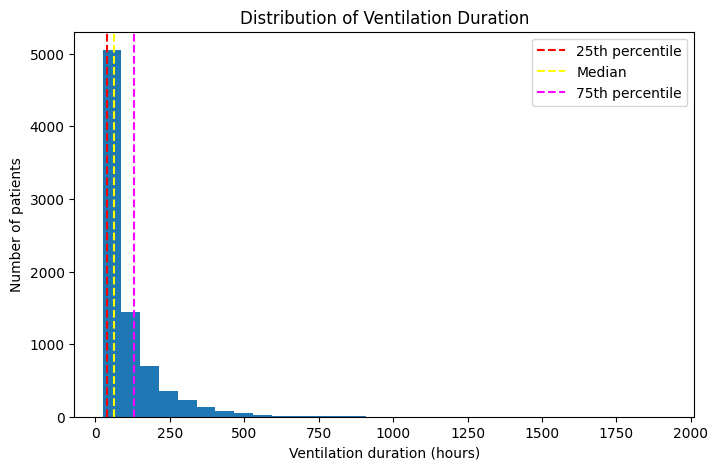

In [13]:
plt.figure(figsize=(8, 5))
plt.hist(db_clean['ventilation_hours'], bins=30)

plt.axvline(percentiles.loc[0.25],
            linestyle='--',
            color='red',
            label='25th percentile')

plt.axvline(percentiles.loc[0.50],
            linestyle='--',
            color='yellow',
            label='Median')

plt.axvline(percentiles.loc[0.75],
            linestyle='--',
            color='magenta',
            label='75th percentile')

plt.xlabel('Ventilation duration (hours)')
plt.ylabel('Number of patients')
plt.title('Distribution of Ventilation Duration')

plt.legend()
plt.show()

## 5. Ventilation Duration vs Clinical Outcome

C:\Users\clau_\AppData\Local\Temp\ipykernel_23412\1075501668.py:3: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  db_clean.to_sql('patients', conn, index=False, if_exists='replace') #Creating a table with the df


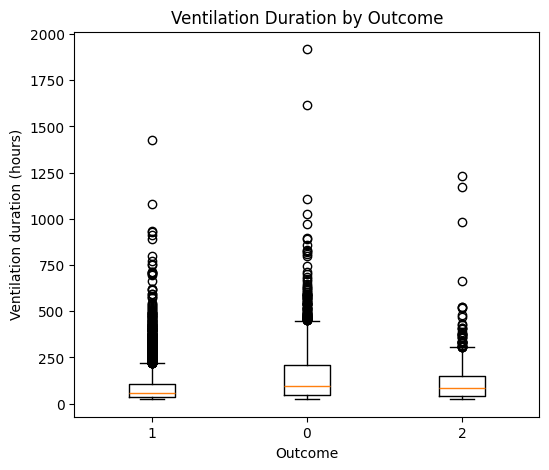

In [14]:
# Aggregate ventilation duration by outcome using SQL
conn = sqlite3.connect(':memory:')
db_clean.to_sql('patients', conn, index=False, if_exists='replace') #Creating a table with the df

query = """
SELECT
    outcome,
    COUNT(*) AS n_patients,
    AVG(ventilation_hours) AS mean_ventilation_hours
FROM patients
GROUP BY outcome;
"""

df_outcome_vent = pd.read_sql(query, conn)
df_outcome_vent

plt.figure(figsize=(6, 5))
plt.boxplot(
    [db_clean[db_clean['outcome'] == o]['ventilation_hours']
     for o in db_clean['outcome'].unique()],
    labels=db_clean['outcome'].unique()
)

plt.xlabel('Outcome')
plt.ylabel('Ventilation duration (hours)')
plt.title('Ventilation Duration by Outcome')

plt.show()

## 6. Age Distribution vs Clinical Outcome

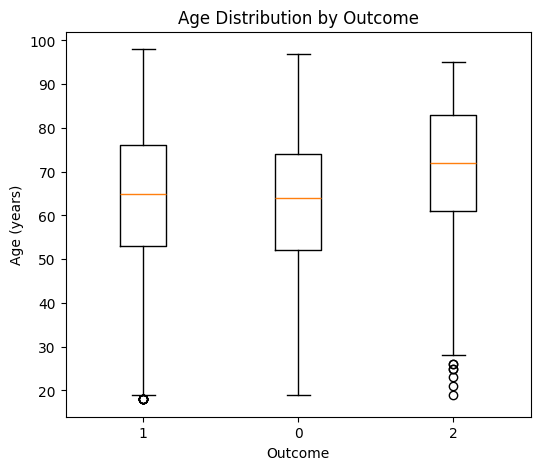

In [15]:
plt.figure(figsize=(6, 5))

outcomes = db_clean['outcome'].unique()
data_by_outcome = [
    db_clean[db_clean['outcome'] == o]['age']
    for o in outcomes
]

plt.boxplot(data_by_outcome, labels=outcomes)

plt.xlabel('Outcome')
plt.ylabel('Age (years)')
plt.title('Age Distribution by Outcome')

plt.show()


## 7. Gender Distribution vs Clinical Outcome

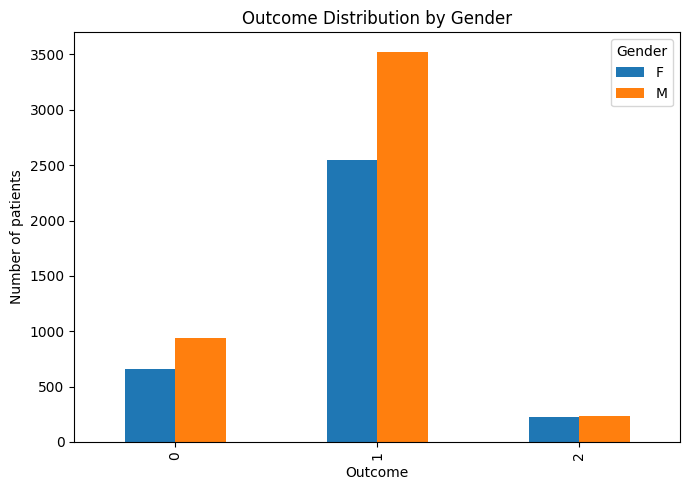

In [16]:
query = """
SELECT
    outcome,
    gender,
    COUNT(*) AS n_patients
FROM patients
GROUP BY outcome, gender;
"""
df_sex_outcome = pd.read_sql(query, conn)
df_sex_outcome


pivot_sex = df_sex_outcome.pivot(
    index='outcome',
    columns='gender',
    values='n_patients'
)
pivot_sex

pivot_sex.plot(kind='bar', figsize=(7, 5))

plt.xlabel('Outcome')
plt.ylabel('Number of patients')
plt.title('Outcome Distribution by Gender')
plt.legend(title='Gender')

plt.tight_layout()
plt.show()

## 8. Conclusions

- Ventilation duration shows a highly right-skewed distribution.
- Patients with worse clinical outcomes tend to have longer ventilation durations.
- Age appears to be associated with outcome, suggesting a potential confounding effect.

This analysis demonstrates an end-to-end data analysis workflow applied to a real-world healthcare dataset.